In [15]:
from bhtsne import tsne
from sklearn.datasets import load_iris
import matplotlib.pyplot as plt

In [57]:
iris = load_iris()
print(iris.data.__class__)
print(iris.data.dtype)
iris.data.shape

<class 'numpy.ndarray'>
float64


(150, 4)

In [17]:
Y = tsne(iris.data)

In [18]:
Y.shape

(150, 2)

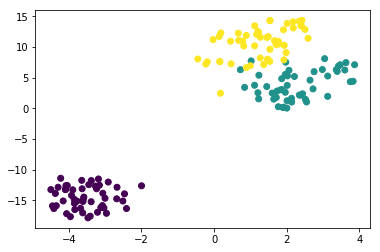

In [19]:
plt.scatter(Y[:, 0], Y[:, 1], c=iris.target)
plt.show()

In [22]:
import os
import logging
import statistics

import pandas as pd
import matplotlib.pyplot as plt

import gym

gym.undo_logger_setup()  # NOQA
from chainer import functions as F
from chainer import links as L
from chainer import optimizers
import numpy as np

import chainerrl
from chainerrl.action_value import DiscreteActionValue
from chainerrl import agents
from chainerrl import experiments
from chainerrl import explorers
from chainerrl import links
from chainerrl import misc
from chainerrl.q_functions import DuelingDQN
from chainerrl import replay_buffer

import atari_wrappers

/Users/sykwer/work/i18-sykwer/visualize_atari/venv/lib/python3.7/site-packages/gym/__init__.py:15: UserWarning: gym.undo_logger_setup is deprecated. gym no longer modifies the global logging configuration
  warnings.warn("gym.undo_logger_setup is deprecated. gym no longer modifies the global logging configuration")


In [23]:
random_seed = 1
outdir = "results"
env_name = "BreakoutNoFrameskip-v4"
load_dir = "../visualize_atari/results/211288/20180804T155228.325999/10000000_finish"

In [24]:
def make_env():
    env = atari_wrappers.wrap_deepmind(
        atari_wrappers.make_atari(env_name),
        episode_life=False, clip_rewards=False
    )
    env.seed(random_seed)
    # misc.env_modifiers.make_rendered(env)
    return env
env = make_env()

In [25]:
print("observation space shape: {}".format(env.observation_space.shape))
print("action size: {}".format(env.action_space.n))

observation space shape: (4, 84, 84)
action size: 4


In [26]:
q_func = links.Sequence(
    links.NatureDQNHead(activation=F.relu),
    L.Linear(512, env.action_space.n),
    DiscreteActionValue,
)
opt = optimizers.RMSpropGraves(lr=2.5e-4, alpha=0.95, momentum=0.0, eps=1e-2)
opt.setup(q_func)
rep_buf = replay_buffer.ReplayBuffer(10 ** 6)
explorer = explorers.LinearDecayEpsilonGreedy(
    1,0, 0.1, 10 ** 6, lambda: np.random.randint(env.action_space.n),
)

In [27]:
agent = agents.DQN(q_func, opt, rep_buf, gpu=-1, gamma=0.99, explorer=explorer, replay_start_size=5 * 10**4,
           target_update_interval=10**4, clip_delta=True, update_interval=4, batch_accumulator="sum",
            phi=lambda x: np.asarray(x, np.float32) / 255)
agent.load(load_dir)

In [30]:
# memo -----

head_conv_layer = q_func.layers[0]
fc_layer = q_func.layers[1]
last_layer = q_func.layers[2]

In [32]:
obs = env.reset()
ipt = agent.batch_states([np.asarray(obs)], agent.xp, agent.phi)

In [35]:
ipt2 = head_conv_layer(ipt)
ipt2.shape

(1, 512)

In [36]:
ipt3 = fc_layer(ipt2)
ipt3.shape

(1, 4)

In [38]:
output = last_layer(ipt3)
ipt3.shape
# end --------

(1, 4)

In [61]:
conv_acti_list = []
fc_acti_list = []
image_list = []

obs = env.reset()
done = False
test_r = 0
t = 0

while not (done or t == 1800):
    image_list.append(env.render(mode="rgb_array"))
    
    head_conv_layer = q_func.layers[0]
    fc_layer = q_func.layers[1]
    ipt = agent.batch_states([np.asarray(obs)], agent.xp, agent.phi)
    
    conv_acti = head_conv_layer(ipt)
    fc_acti = fc_layer(conv_acti)
    
    conv_acti_list.append(conv_acti[0].data)
    fc_acti_list.append(fc_acti[0].data)
    
    a = agent.act(obs)
    obs, r, done, info = env.step(a)
    test_r += r
    t += 1

agent.stop_episode()
print("episode reward: {}".format(test_r))

episode reward: 227.0


In [63]:
conv_acti_list = np.array(conv_acti_list).astype(np.float64)
fc_acti_list = np.array(fc_acti_list).astype(np.float64)

In [66]:
tsne_conv_activation = tsne(conv_acti_list)

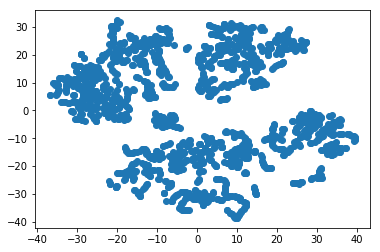

In [67]:
plt.scatter(tsne_conv_activation[:, 0], tsne_conv_activation[:, 1])
plt.show()

In [68]:
tsne_fc_activation = tsne(fc_acti_list)

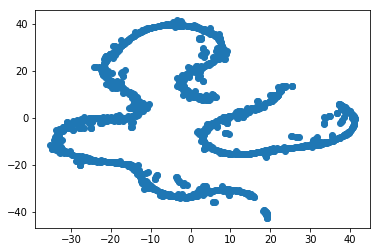

In [69]:
plt.scatter(tsne_fc_activation[:, 0], tsne_fc_activation[:, 1])
plt.show()